# Regression with Amazon SageMaker XGBoost (Parquet input)

This notebook exhibits the use of a Parquet dataset for use with the SageMaker XGBoost algorithm. The example here is almost the same as [Regression with Amazon SageMaker XGBoost algorithm](xgboost_abalone.ipynb).

This notebook tackles the exact same problem with the same solution, but has been modified for a Parquet input. 
The original notebook provides details of dataset and the machine learning use-case.

This notebook has been tested using the Python 3 (Data Science) kernel.

In [1]:
import os
import boto3
import re
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
region = boto3.Session().region_name

# S3 bucket for saving code and model artifacts.
# Feel free to specify a different bucket here if you wish.
bucket = sagemaker.Session().default_bucket()
prefix = "sagemaker/DEMO-xgboost-parquet"
bucket_path = "https://s3-{}.amazonaws.com/{}".format(region, bucket)

We will use [PyArrow](https://arrow.apache.org/docs/python/) library to store the Abalone dataset in the Parquet format. 

In [2]:
!python -m pip install pyarrow==0.15

     |████████████████████████████████| 60.5 MB 61 kB/s  eta 0:00:01     |█████████████████▍              | 32.9 MB 3.0 MB/s eta 0:00:10     |███████████████████▊            | 37.2 MB 3.0 MB/s eta 0:00:08███████████████▉          | 41.2 MB 3.0 MB/s eta 0:00:07


In [3]:
%%time

import numpy as np
import pandas as pd
import urllib.request
from sklearn.datasets import load_svmlight_file

# Download the dataset and load into a pandas dataframe
FILE_NAME = "abalone.csv"
urllib.request.urlretrieve(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data", FILE_NAME
)
feature_names = [
    "Sex",
    "Length",
    "Diameter",
    "Height",
    "Whole weight",
    "Shucked weight",
    "Viscera weight",
    "Shell weight",
    "Rings",
]
data = pd.read_csv(FILE_NAME, header=None, names=feature_names)

# SageMaker XGBoost has the convention of label in the first column
data = data[feature_names[-1:] + feature_names[:-1]]
data["Sex"] = data["Sex"].astype("category").cat.codes

# Split the downloaded data into train/test dataframes
train, test = np.split(data.sample(frac=1), [int(0.8 * len(data))])

# requires PyArrow installed
train.to_parquet("abalone_train.parquet")
test.to_parquet("abalone_test.parquet")

CPU times: user 265 ms, sys: 35.8 ms, total: 300 ms
Wall time: 974 ms


In [4]:
%%time
sagemaker.Session().upload_data(
    "abalone_train.parquet", bucket=bucket, key_prefix=prefix + "/" + "train"
)

sagemaker.Session().upload_data(
    "abalone_test.parquet", bucket=bucket, key_prefix=prefix + "/" + "test"
)

CPU times: user 201 ms, sys: 12.7 ms, total: 214 ms
Wall time: 366 ms


's3://sagemaker-us-east-2-900597767885/sagemaker/DEMO-xgboost-parquet/test/abalone_test.parquet'

We obtain the new container by specifying the framework version (0.90-1). This version specifies the upstream XGBoost framework version (0.90) and an additional SageMaker version (1). If you have an existing XGBoost workflow based on the previous (0.72) container, this would be the only change necessary to get the same workflow working with the new container.

In [5]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(region, "xgboost", "0.90-1")

After setting training parameters, we kick off training, and poll for status until training is completed, which in this example, takes between 5 and 6 minutes.

In [6]:
%%time
import time
from time import gmtime, strftime

job_name = "xgboost-parquet-example-training-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Training job", job_name)

# Ensure that the training and validation data folders generated above are reflected in the "InputDataConfig" parameter below.

create_training_params = {
    "AlgorithmSpecification": {"TrainingImage": container, "TrainingInputMode": "Pipe"},
    "RoleArn": role,
    "OutputDataConfig": {"S3OutputPath": bucket_path + "/" + prefix + "/single-xgboost"},
    "ResourceConfig": {"InstanceCount": 1, "InstanceType": "ml.m5.24xlarge", "VolumeSizeInGB": 20},
    "TrainingJobName": job_name,
    "HyperParameters": {
        "max_depth": "5",
        "eta": "0.2",
        "gamma": "4",
        "min_child_weight": "6",
        "subsample": "0.7",
        "silent": "0",
        "objective": "reg:linear",
        "num_round": "10",
    },
    "StoppingCondition": {"MaxRuntimeInSeconds": 3600},
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + "/" + prefix + "/train",
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "ContentType": "application/x-parquet",
            "CompressionType": "None",
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + "/" + prefix + "/test",
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "ContentType": "application/x-parquet",
            "CompressionType": "None",
        },
    ],
}


client = boto3.client("sagemaker", region_name=region)
client.create_training_job(**create_training_params)

status = client.describe_training_job(TrainingJobName=job_name)["TrainingJobStatus"]
print(status)
while status != "Completed" and status != "Failed":
    time.sleep(60)
    status = client.describe_training_job(TrainingJobName=job_name)["TrainingJobStatus"]
    print(status)

Training job xgboost-parquet-example-training-2020-05-12-22-22-23
InProgress
InProgress
InProgress
Completed
CPU times: user 89.2 ms, sys: 6.95 ms, total: 96.1 ms
Wall time: 3min


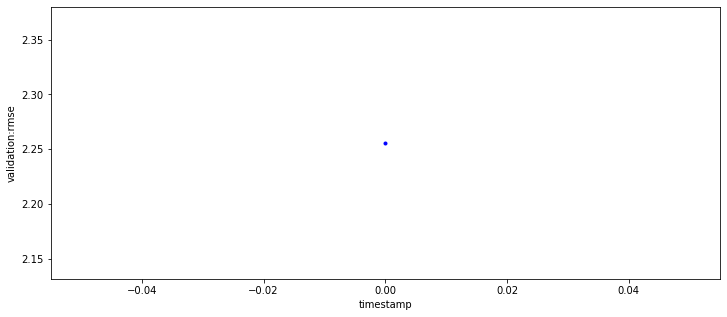

In [7]:
%matplotlib inline
from sagemaker.analytics import TrainingJobAnalytics

metric_name = "validation:rmse"

metrics_dataframe = TrainingJobAnalytics(
    training_job_name=job_name, metric_names=[metric_name]
).dataframe()
plt = metrics_dataframe.plot(
    kind="line", figsize=(12, 5), x="timestamp", y="value", style="b.", legend=False
)
plt.set_ylabel(metric_name);